# Shared response model
This notebook provides interactive examples of functional alignment using the shared response model (SRM; [Chen et al., 2015](https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model)). BrainIAK includes several options that depend on the user needs. The most basic method is the [Shared Response Model](https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model) (SRM). The main idea behind this method is to capture what is common across participants performing the same task. Given data that is synchronized in the temporal dimension across a group of subjects, SRM computes a low dimensional *shared* feature subspace common to all subjects. The method also constructs orthogonal weights to project from the shared subspace to each subject voxel space.

The functional alignment module simplifies the import and interchange among these methods. The module includes the following variations of SRM:
* SRM: A probabilistic version of SRM
* DetSRM: A deterministic version of SRM
* RSRM: Robust SRM for better filtering idiosyncratic components and outliers in data
* SSSRM: Semi-Supervised SRM for introducing partial labelled data  
* FastSRM: A faster version that projects the data into  
* Conectivity SRM: Estimate SRM on functional connectivity data

In [2]:
# Import necessary python modules
from glob import glob
import nibabel as nib
import numpy as np
from nilearn.plotting import plot_stat_map
from scipy.stats import zscore
import matplotlib.pyplot as plt
import brainiak.funcalign.srm
from brainiak.fcma.util import compute_correlation

### Example fMRI data and atlas
To work through the SRM functionality, we use an fMRI dataset collected while participants listened to a spoken story called "[I Knew You Were Black](https://themoth.org/stories/i-knew-you-were-black)" by Carol Daniel. These data are available as part of the publicly available [Narratives](https://github.com/snastase/narratives) collection ([Nastase et al., 2019](https://openneuro.org/datasets/ds002345)). Here, we download a pre-packaged subset of the data from Zenodo. These data have been preprocessed using fMRIPrep and confound regression in AFNI. We apply the SRM to a region of interest (ROI) comprising the "temporal parietal" network according to a cortical parcellation containing 400 parcels from Schaefer and colleagues ([2018](https://doi.org/10.1093/cercor/bhx179)).

In [14]:
# Download example fMRI data and atlas from Zenodo
data_fns = sorted(glob('../data/sub-*_task-black_*bold.nii.gz'))
atlas_fn = '../data/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2.5mm.nii.gz'

# Load in the Schaefer 400-parcel atlas
atlas_nii = nib.load(atlas_fn)
atlas_img = atlas_nii.get_fdata()

# Left temporal parietal ROI labels
parcel_labels = [195, 196, 197, 198, 199, 200]

In [15]:
# Load in intact functional data and compute parcel means
data = []
for data_fn in data_fns:
    voxel_data = nib.load(data_fn).get_fdata()
    roi_data = np.column_stack([voxel_data[atlas_img == parcel, :].T
                                for parcel in parcel_labels])
    data.append(roi_data)

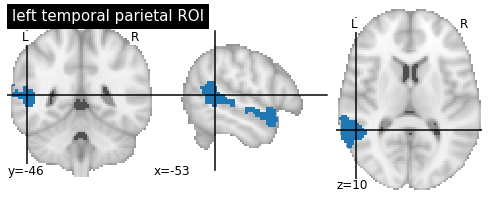

In [51]:
# Visualize the left temporal parietal ROI
roi_img = np.zeros(atlas_img.shape)
for parcel in parcel_labels:
    roi_img[atlas_img == parcel] = 1

# Convert to a NIfTI image for visualization with Nilearn
roi_nii = nib.Nifti1Image(roi_img, atlas_nii.affine, atlas_nii.header)

# Plot plot left temporal parietal ROI
plot_stat_map(roi_nii, cmap='tab10_r', cut_coords=(-53, -46, 10),
              colorbar=False, title='left temporal parietal ROI')

In [48]:
# @SAM: Here we need to describe the data and load it
# I am assumming that we load it in a variable named "data" and it is a list with each subject's data as a matrix
# data[i] is data for ith subject with dimensions V_i x T, with V_i the number of voxels 
# for subject i and T the number of TRs
n_subjects = len(data) # Number of subjects
n_trs = data[0].shape[0] # Total TRs: 550

Once data is loaded, we divide the data into two halves for a two fold validation.
We will use one half for training SRM and the other for testing its performance.
Then, we normalize the data each half.

In [57]:
train_data = []
test_data = []
for subject in np.arange(n_subjects):
    
    # Take the first half of TRs as training
    train_data.append(zscore(data[subject][:n_trs//2, :], axis=0).T)
    
    # Take the second half of TRs as testing
    test_data.append(zscore(data[subject][(n_trs//2):, :], axis=0).T)

### Fitting the SRM
Next, we train the SRM model on the training data. 
Therefore, we need to define the dimension of the desired feature space.
A good methodology to find a good value is to apply cross-validation.

Also, we need to define the number of iterations that the SRM algorithm should run. Ideally, this number should be high enough so the algorithm converges.

In [58]:
features = 50  # The dimension of the feature space
n_iter = 10  # Number of iterations to perform.

# Create an SRM object
srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features)

# Fit the SRM data
print('Fitting SRM')
srm.fit(train_data)
print('SRM has been fit')
print(f'Share response shape: {srm.s_.shape[0]} Features x {srm.s_.shape[1]} Time-points')

Fitting SRM
SRM has been fit
Share response shape: 50 Features x 275 Time-points


After training SRM, we obtain a shared response $S$ that contains the values of the features for each TR, and a set of weight matrices $W_i$ that can project from the shared subspace to a specific subject voxel space.

Let us check the orthogonal property of the weight matrix $W_i$ for a subject.
We visualize $W_i^TW_i$ that should be the identity $I$ matrix of shape equal to the number of features we selected.

Weight matrix shape: 935 Voxels x 50 Features


Text(0.5, 1.05, 'Weight matrix test for orthogonality for subject 0')

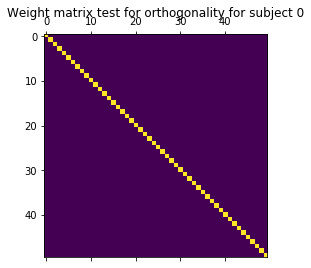

In [65]:
subject = 0
print(f'Weight matrix shape: {srm.w_[subject].shape[0]} Voxels x {srm.w_[subject].shape[1]} Features')

plt.matshow(srm.w_[0].T.dot(srm.w_[0]))
plt.title(f'Weight matrix test for orthogonality for subject {subject}') 

# Testing the performance of SRM: Time Segment Matching

When we trained SRM above, we learned the weight matrices $W_i$ and the shared response $S$ for the training data. The weight matrices further allow us to convert new data to the shared feature space. We call the `transform()` function to convert new data for each subject. Then, we normalize for additional analysis.

In [69]:
test_shared[0].shape

(50, 275)

In [75]:
# Transform subject-space test data into shared space
test_shared = srm.transform(test_data)

# z-score the transformed test data
test_shared = [zscore(ts, axis=1) for ts in test_shared]

The function below replicates the Time Segment Matching experiment proposed by [Chen et al.](https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model). The function receives the data from `N` subjects as argument and a window size for the time segments. A segment is the concatenation of `win_size` TRs. Then, using the averaged data from `N-1` subjects it tries to match the segments from the left out subject to the right position. The function returns the average accuracy across segments for each subject.

In [73]:
def time_segment_matching(data, win_size=10): 
    nsubjs = len(data)
    (ndim, nsample) = data[0].shape
    accuracy = np.zeros(shape=nsubjs)
    nseg = nsample - win_size 
    
    # mysseg prediction
    trn_data = np.zeros((ndim*win_size, nseg),order='f')
    
    # the training data also include the test data, but will be subtracted when calculating A
    for m in range(nsubjs):
        for w in range(win_size):
            trn_data[w*ndim:(w+1)*ndim,:] += data[m][:,w:(w+nseg)]
            
    # Analyze each subject (leave-one-out)
    for tst_subj in range(nsubjs):
        tst_data = np.zeros((ndim*win_size, nseg), order='f')
        for w in range(win_size):
            tst_data[w*ndim:(w+1)*ndim,:] = data[tst_subj][:,w:(w+nseg)]

        A =  np.nan_to_num(stats.zscore((trn_data - tst_data), axis=0, ddof=1))
        B =  np.nan_to_num(stats.zscore(tst_data, axis=0, ddof=1))

        # compute correlation matrix
        corr_mtx = compute_correlation(B.T,A.T)

        # The correlation classifier.
        for i in range(nseg):
            for j in range(nseg):
                # exclude segments overlapping with the testing segment
                if abs(i-j)<win_size and i != j :
                    corr_mtx[i,j] = -np.inf
        max_idx =  np.argmax(corr_mtx, axis=1)
        accuracy[tst_subj] = sum(max_idx == range(nseg)) / nseg

        # Print accuracy
        print("Accuracy for subj %d is: %0.4f" % (tst_subj, accuracy[tst_subj] ))
        
    print("The average accuracy among all subjects is {0:f} +/- {1:f}".format(np.mean(accuracy), np.std(accuracy)))
    return accuracy

Let's compute time segment matching accuracy for the raw data:

In [74]:
accuracy_raw_train = time_segment_matching(train_data, win_size=10)
accuracy_raw_test = time_segment_matching(test_data, win_size=10)
boxplot_data = [accuracy_raw_train, accuracy_raw_test]
labels = ['Raw train', 'Raw test']

Accuracy for subj 0 is: 0.1245
Accuracy for subj 1 is: 0.1509
Accuracy for subj 2 is: 0.0604
Accuracy for subj 3 is: 0.0717
Accuracy for subj 4 is: 0.1849
Accuracy for subj 5 is: 0.0868
Accuracy for subj 6 is: 0.0566
Accuracy for subj 7 is: 0.2415
Accuracy for subj 8 is: 0.0226
Accuracy for subj 9 is: 0.1962
Accuracy for subj 10 is: 0.2453
Accuracy for subj 11 is: 0.0566
Accuracy for subj 12 is: 0.0717
Accuracy for subj 13 is: 0.2642
Accuracy for subj 14 is: 0.2226
Accuracy for subj 15 is: 0.1887
Accuracy for subj 16 is: 0.2189
Accuracy for subj 17 is: 0.0642
Accuracy for subj 18 is: 0.0981
Accuracy for subj 19 is: 0.0943
Accuracy for subj 20 is: 0.0906
Accuracy for subj 21 is: 0.0604
Accuracy for subj 22 is: 0.2189
Accuracy for subj 23 is: 0.1358
Accuracy for subj 24 is: 0.2566
Accuracy for subj 25 is: 0.0528
Accuracy for subj 26 is: 0.0302
Accuracy for subj 27 is: 0.0943
Accuracy for subj 28 is: 0.1321
Accuracy for subj 29 is: 0.0717
Accuracy for subj 30 is: 0.2189
Accuracy for subj 

Now, we compute it after transforming the subjects data with SRM

In [77]:
accuracy_shared = time_segment_matching(test_shared, win_size=10)
boxplot_data.append(accuracy_shared)
labels.append('SRM test')

Accuracy for subj 0 is: 0.3019
Accuracy for subj 1 is: 0.4755
Accuracy for subj 2 is: 0.2717
Accuracy for subj 3 is: 0.0566
Accuracy for subj 4 is: 0.8340
Accuracy for subj 5 is: 0.1547
Accuracy for subj 6 is: 0.2717
Accuracy for subj 7 is: 0.2868
Accuracy for subj 8 is: 0.3774
Accuracy for subj 9 is: 0.5057
Accuracy for subj 10 is: 0.7132
Accuracy for subj 11 is: 0.0491
Accuracy for subj 12 is: 0.3094
Accuracy for subj 13 is: 0.3623
Accuracy for subj 14 is: 0.8075
Accuracy for subj 15 is: 0.6906
Accuracy for subj 16 is: 0.4717
Accuracy for subj 17 is: 0.1358
Accuracy for subj 18 is: 0.3472
Accuracy for subj 19 is: 0.2566
Accuracy for subj 20 is: 0.4868
Accuracy for subj 21 is: 0.5245
Accuracy for subj 22 is: 0.3434
Accuracy for subj 23 is: 0.0906
Accuracy for subj 24 is: 0.5208
Accuracy for subj 25 is: 0.1358
Accuracy for subj 26 is: 0.0943
Accuracy for subj 27 is: 0.6453
Accuracy for subj 28 is: 0.4038
Accuracy for subj 29 is: 0.3849
Accuracy for subj 30 is: 0.5434
Accuracy for subj 

Last, we plot the results to see what method performs best. 

Text(0.5, 1.0, 'Time Segment Matching')

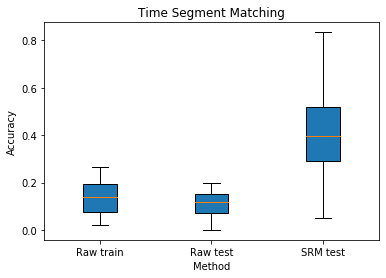

In [79]:
plt.figure()
plt.boxplot(boxplot_data, vert=True, patch_artist=True, labels=labels)
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Time Segment Matching')

#### References
* Chen, P. H. C., Chen, J., Yeshurun, Y., Hasson, U., Haxby, J., & Ramadge, P. J. (2015). A reduced-dimension fMRI shared response model. In C. Cortes, N.D. Lawrence, D.D. Lee, M. Sugiyama, R. Garnett (Eds.), *Advances in Neural Information Processing Systems, vol. 28* (pp. 460-468). https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model

* Nastase, S. A., Liu, Y. F., Hillman, H., Norman, K. A., & Hasson, U. (2020). Leveraging shared connectivity to aggregate heterogeneous datasets into a common response space. *NeuroImage*, *217*, 116865. https://doi.org/10.1016/j.neuroimage.2020.116865